c:\python27\lib\site-packages\ipykernel_launcher.py:69: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


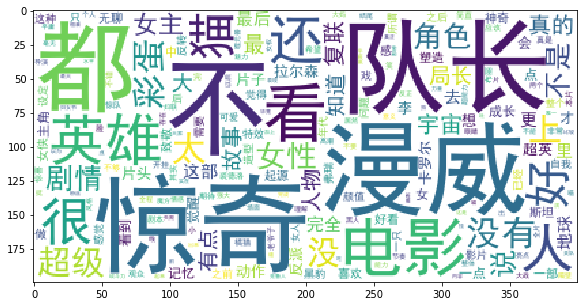

In [6]:
import urllib2
from bs4 import BeautifulSoup
import re
import jieba
import pandas as pd
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
from wordcloud import WordCloud

def get_now_playing_movie_list():
    resp = urllib2.urlopen('https://movie.douban.com/nowplaying/hangzhou/')
    html_data = resp.read().decode('utf-8')

    soup = BeautifulSoup(html_data, 'html.parser')
    nowplaying_movie = soup.find_all('div', id='nowplaying')
    nowplaying_movie_list = nowplaying_movie[0].find_all('li', class_='list-item')

    nowplaying_list = []
    for item in nowplaying_movie_list:
        nowplaying_dict = {}
        nowplaying_dict['id'] = str(item['data-subject'])
        nowplaying_dict['name'] = item['data-title']
        nowplaying_list.append(nowplaying_dict)

    return nowplaying_list

def get_comments_by_id(movie_id, pageNum):
    if pageNum > 0:
        start = (pageNum-1)*20
    else:
        return False
    url = 'https://movie.douban.com/subject/' + movie_id + '/comments?start=' + str(start) + '&limit=20'
    resp = urllib2.urlopen(url)
    html_data = resp.read().decode('utf-8')
    soup = BeautifulSoup(html_data, 'html.parser')
    comment_div_list = soup.find_all('div', class_='comment')
    each_comment_list = []
    for item in comment_div_list:
        if item.find_all('p')[0].text is not None:
            each_comment_list.append(item.find_all('p')[0].text)

    return each_comment_list

def main():
    now_playing_movie_list = get_now_playing_movie_list()
    comment_list = []
    for i in range(8):
        num = i + 1
        comment_list_temp = get_comments_by_id(now_playing_movie_list[0]['id'], num)
        comment_list = comment_list + comment_list_temp

    comments = ''
    for comment in comment_list:
        comments = comments + comment.strip()

    pattern = re.compile(ur'[\u4e00-\u9fa5]+')
    filter_data = re.findall(pattern, comments)
    cleaned_comments = ''.join(filter_data)

    segment = jieba.lcut(cleaned_comments)
    words_df = pd.DataFrame({'segment': segment})

    stopwords = pd.read_csv("stopwords.txt", index_col=False, quoting=3, sep="\t", names=['stopword'],encoding='utf-8')
    words_df = words_df[~words_df.segment.isin(stopwords.stopword)]

    words_stat = words_df.groupby(by=['segment'])['segment'].agg({"Count": numpy.size})
    words_stat = words_stat.reset_index().sort_values(by=["Count"], ascending=False)

    wordcloud = WordCloud(font_path="simhei.ttf", background_color="white", max_font_size=80)
    word_frequence = {x[0]: x[1] for x in words_stat.head(1000).values}
    word_frequence_dict = {}
    for key in word_frequence:
        word_frequence_dict[key] = word_frequence[key]

    wordcloud = wordcloud.fit_words(word_frequence_dict)
    plt.imshow(wordcloud)


if __name__ == '__main__':
    main()
